##### Please refer to the pdf file for explanation of evertything
##### While the codes are commented, they are not explained

# Q1 (3-18)

In [1]:
%reset -f

relaxed objective: -34.4172
best t_index: 56, t: 0.56
Upper bound: -33.5773, lower bound: -34.4172, U - L: 0.8400, frac: 102.50 %


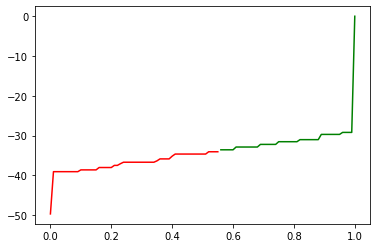

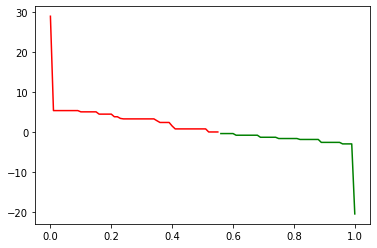

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

np.random.seed(0)
(m, n) = (300, 100)

A = np.random.rand(m, n)
b = A.dot(np.ones(n))/2
c = -np.random.rand(n)
x = cp.Variable(n)
relaxed_obj = cp.Minimize(c @ x)
constraints = [
        A @ x <= b,
        x >= 0,
        x <= 1,
        ]
problem = cp.Problem(relaxed_obj, constraints)
problem.solve()
lower_bound = problem.value
print(f"relaxed objective: {lower_bound:.4f}")

t_count = 101
t_values = np.linspace(0, 1, t_count)
obj_value = np.zeros(t_count)
maximum_violation = np.zeros(t_count)

for i, t in enumerate(t_values):
    new_x = (x.value > t).astype(int)
    obj_value[i] = np.dot(c, new_x)
    maximum_violation[i] = np.max(np.matmul(A, new_x) - b)

good_indexes = np.arange(t_count)[maximum_violation <= 0]
best_t_index = good_indexes[np.argmin(obj_value[good_indexes])]
print(f"best t_index: {best_t_index}, t: {t_values[best_t_index]}")
upper_bound = obj_value[best_t_index]
U_minus_L = upper_bound - lower_bound
frac = lower_bound / upper_bound
print(f"Upper bound: {upper_bound:.4f}, lower bound: {lower_bound:.4f}, U - L: {U_minus_L:.4f}, frac: {(frac * 100):.2f} %")

feasible = maximum_violation <= 0
plt.plot(t_values[feasible], obj_value[feasible], color='green')
plt.plot(t_values[~feasible], obj_value[~feasible], color='red')
plt.show()
plt.plot(t_values[feasible], maximum_violation[feasible], color='green')
plt.plot(t_values[~feasible], maximum_violation[~feasible], color='red')
plt.show()

# Q2(3.20)

In [3]:
%reset -f

status: optimal
Total fuel: 2617.825193521739


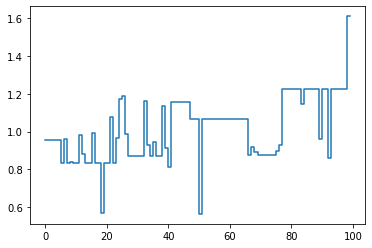

In [4]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

from veh_speed_sched_data import n, a, b, c, d, smin, smax, tau_min, tau_max
#fixing data
d = np.asarray(d)
smin = np.asarray(smin)
smax = np.asarray(smax)
tau_min = np.asarray(tau_min)
tau_max = np.asarray(tau_max)

d = d[:,0]
smin = smin[:,0]
smax = smax[:,0]
tau_min = tau_min[:,0]
tau_max = tau_max[:,0]

k = cp.Variable(n)
h = cp.cumsum(k)
phi = a * cp.multiply(cp.inv_pos(k), d**2) + c * k + cp.multiply(b, d)
obj = cp.Minimize(cp.sum(phi))
constraints = [
        cp.multiply(smin, k) <= d,
        cp.multiply(smax, k) >= d,
        tau_min <= h,
        tau_max >= h,
        ]
problem = cp.Problem(obj, constraints)
problem.solve()
print(f"status: {problem.status}")
if problem.status == 'optimal':
    print(f"Total fuel: {problem.value}")
    s = d / k.value
    plt.step(np.arange(n), s)
    plt.show()

# Q4 (3.28)

In [5]:
%reset -f

In [6]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from functools import reduce
from operator import add

#ci is short for convert index
def convert_index(*args):
    return reduce(lambda x, y: x * 2 + y, args)

all_tuples = [(i, j, k, l) for i in range(2) for j in range(2) for k in range(2) for l in range(2)]
def get_prob(p=None, i=None, j=None, k=None, l=None):
    def is_fine(i0, j0, k0, l0):
        a = [i, j, k, l]
        b = [i0, j0, k0, l0]
        return all(i == ip or i is None for i, ip in zip(a, b))
    return reduce(add, [p[convert_index(i, j, k, l)] for i, j, k, l in all_tuples if is_fine(i, j, k, l)])

p = cp.Variable(16)
constraints = [
        get_prob(p) == 1,
        get_prob(p, i=1) == 0.9,
        get_prob(p, j=1) == 0.9,
        get_prob(p, k=1) == 0.1,
        get_prob(p, i=1, l=0, k=1) == 0.7 * get_prob(p, k=1),
        get_prob(p, l=1, j=1, k=0) == 0.6 * get_prob(p, j=1, k=0),
        p >= 0,
        ]
obj1 = cp.Minimize(get_prob(p, l=1))
obj2 = cp.Maximize(get_prob(p, l=1))
p1 = cp.Problem(obj1, constraints)
p2 = cp.Problem(obj2, constraints)
p1.solve()
p2.solve()

print(f"minimum X_4: {p1.value:.2f}")
print(f"maximum X_4: {p2.value:.2f}")

minimum X_4: 0.48
maximum X_4: 0.61


# Q5(4.1)

In [7]:
%reset -f

## Part A

In [8]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from functools import reduce
EPSILON = 1e-8
#verifies a condition or a vector of conditions
def verify(condition, text=" ", indentaion=0):
    if np.all(condition):
        print(f"{' ' * 8 * indentaion}condition {text} verified")
    else:
        print(f"{' ' * 8 * indentaion}condition {text} violated")
#verifies that a value is zero
def verify_zero(value, *args, **kwargs):
    verify(np.abs(value) <= 0 + EPSILON, *args, **kwargs)

#solving original problem
perturb = (0, 0)
u1, u2 = -2 + perturb[0], -3 + perturb[1]
P = np.array([[1, -1/2], [-1/2, 2]])
q = np.array([-1, 0])
A = np.array([[1, 2], [1, -4], [5, 76]])
b = np.array([u1, u2, 1])
x = cp.Variable(2)

obj = cp.Minimize(cp.quad_form(x, P) + q @ x)
constraints = [
        A @ x <= b,
        ]
problem = cp.Problem(obj, constraints)
problem.solve()

#just checking everthing is fine
assert problem.status == 'optimal'

np.set_printoptions(precision=3)
print(f"Optimal value: {problem.value:.4f}")
print(f"Optimal x: {x.value}")
print(f"Optimal lambda: {constraints[0].dual_value}")
print("Verifying KKT")
print("Going by the order in page 244 of the book")
x_bar = x.value
lambda_bar = constraints[0].dual_value
verify(np.dot(A, x_bar) - b <= 0 + EPSILON, "f_i(x_bar) <= 0")
verify(lambda_bar >= EPSILON, "lambda >= 0")
verify_zero((np.dot(A, x_bar) - b) * lambda_bar, "lambda_bar * f_i(x_bar) = 0")
verify_zero(2 * P.dot(x_bar) + q + lambda_bar.dot(A), "Gradient condition")



Optimal value: 8.2222
Optimal x: [-2.333  0.167]
Optimal lambda: [2.748 2.885 0.04 ]
Verifying KKT
Going by the order in page 244 of the book
condition f_i(x_bar) <= 0 verified
condition lambda >= 0 verified
condition lambda_bar * f_i(x_bar) = 0 verified
condition Gradient condition verified


## Part b

In [9]:
original_value = problem.value
original_lambda_star = constraints[0].dual_value
li = [0, -0.1, 0.1]
possible_deltas = [(x, y) for x in li for y in li]
for perturb in possible_deltas:
    #calculatin pred
    pred = original_value - original_lambda_star[:2].dot(np.array([*perturb]))
    print(f"perturb = {perturb}")
    print(f"\tp_pred: {pred:.4f}")
    #exact
    u1, u2 = -2 + perturb[0], -3 + perturb[1]
    P = np.array([[1, -1/2], [-1/2, 2]])
    q = np.array([-1, 0])
    A = np.array([[1, 2], [1, -4], [5, 76]])
    b = np.array([u1, u2, 1])
    x = cp.Variable(2)

    obj = cp.Minimize(cp.quad_form(x, P) + q @ x)
    constraints = [
            A @ x <= b,
            ]
    problem = cp.Problem(obj, constraints)
    problem.solve()
    if problem.status != 'optimal':
        print(f"\tcould'nt solve! status={problem.status}")
    else:
        print(f"\tp_exact = {problem.value:.4f}")
    verify(pred <= problem.value + EPSILON, "pred < exact", indentaion=1)

perturb = (0, 0)
	p_pred: 8.2222
	p_exact = 8.2222
        condition pred < exact verified
perturb = (0, -0.1)
	p_pred: 8.5107
	p_exact = 8.7064
        condition pred < exact verified
perturb = (0, 0.1)
	p_pred: 7.9337
	p_exact = 7.9800
        condition pred < exact verified
perturb = (-0.1, 0)
	p_pred: 8.4970
	p_exact = 8.5650
        condition pred < exact verified
perturb = (-0.1, -0.1)
	p_pred: 8.7855
	p_exact = 8.8156
        condition pred < exact verified
perturb = (-0.1, 0.1)
	p_pred: 8.2085
	p_exact = 8.3189
        condition pred < exact verified
perturb = (0.1, 0)
	p_pred: 7.9474
	p_exact = 8.2222
        condition pred < exact verified
perturb = (0.1, -0.1)
	p_pred: 8.2360
	p_exact = 8.7064
        condition pred < exact verified
perturb = (0.1, 0.1)
	p_pred: 7.6589
	p_exact = 7.7515
        condition pred < exact verified
